# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from math import ceil

# Reading data

In [2]:
files_list = os.listdir('../data')
target_file_name = 'profile.txt'
sensors_list = [file.split('.txt')[0] for file in files_list if file != target_file_name]

In [3]:
target = pd.read_csv(f'../data/{target_file_name}', delimiter='\t', header=None)[3] # 3 is reference to the Hydraulic accumulator

In [4]:
experiment_time_seconds = 60
sensors_data_dict_freq = {}
sensors_names_dict_freq = {}
for sensor in sensors_list:
    df_sensor = pd.read_csv(f'../data/{sensor}.txt', delimiter='\t', header=None)
    n_samples = df_sensor.shape[1]
    freq = n_samples/experiment_time_seconds
    if freq not in sensors_data_dict_freq:
        sensors_data_dict_freq[freq]=df_sensor
        sensors_names_dict_freq[freq]=[sensor]
    else:
        sensors_data_dict_freq[freq]=np.dstack((sensors_data_dict_freq[freq], df_sensor))
        sensors_names_dict_freq[freq]+=[sensor]


In [5]:
for freq, names_list in sensors_names_dict_freq.items():
    n_sensors = len(names_list)
    print(f'There are {n_sensors} sensors with the frequency of {int(freq)} Hz.')

There are 8 sensors with the frequency of 1 Hz.
There are 7 sensors with the frequency of 100 Hz.
There are 2 sensors with the frequency of 10 Hz.


In [6]:
one_hz_data = sensors_data_dict_freq[1]
one_hz_names = sensors_names_dict_freq[1]

ten_hz_data = sensors_data_dict_freq[10]
ten_hz_names = sensors_names_dict_freq[10]

hund_hz_data = sensors_data_dict_freq[100]
hund_hz_names = sensors_names_dict_freq[100]

In [7]:
for freq, data in sensors_data_dict_freq.items():
    print(f'{int(freq)} Hz sensors data shape: {data.shape}')

1 Hz sensors data shape: (2205, 60, 8)
100 Hz sensors data shape: (2205, 6000, 7)
10 Hz sensors data shape: (2205, 600, 2)


# Exploratory Data Analysis

According to the documentation the representation of the target values is:

- Hydraulic accumulator / bar: \
      - 130: optimal pressure (599 instances) \
      - 115: slightly reduced pressure (399 instances) \
      - 100: severely reduced pressure (399 instances) \
      - 90: close to total failure (808 instances)

For easier interpretability I will assume:

- Hydraulic accumulator / bar: \
      - 0: optimal pressure (599 instances) \
      - 1: slightly reduced pressure (399 instances) \
      - 2: severely reduced pressure (399 instances) \
      - 3: close to total failure (808 instances)

In [8]:
rename_target = {
    130:0,
    115:1,
    100:2,
    90:3
}

In [12]:
rename_target = {
    130:0,
    115:1,
    100:2,
    90:3
}
target = target.map(rename_target)

In [13]:
df_count = pd.DataFrame({'condition':target.value_counts().index, 'count':target.value_counts().values})
df_count = df_count.sort_values(by='condition').reset_index(drop=True)
df_count

,condition,count
0,0,599
1,1,399
2,2,399
3,3,808


We can see that we don't have a big difference beetween the conditions of the experiments 

Checking any missing value

In [14]:
def check_missing_values(data:np.ndarray, names:list) -> None:    
    nan_values_sensors = sum(np.isnan(data))
    n_samples_sensor = data.shape[0]*data.shape[1]
    for sensor_idx in range(nan_values_sensors.shape[1]):
        nan_values_sensor = sum(nan_values_sensors[:,sensor_idx])
        nan_values_perc = round(100*nan_values_sensor/n_samples_sensor,2)
        print(f'The sensor {names[sensor_idx]} has {nan_values_perc} % of missing values.')

In [15]:
check_missing_values(one_hz_data, one_hz_names)
check_missing_values(ten_hz_data, ten_hz_names)
check_missing_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of missing values.
The sensor CP has 0.0 % of missing values.
The sensor SE has 0.0 % of missing values.
The sensor TS1 has 0.0 % of missing values.
The sensor TS2 has 0.0 % of missing values.
The sensor TS3 has 0.0 % of missing values.
The sensor TS4 has 0.0 % of missing values.
The sensor VS1 has 0.0 % of missing values.
The sensor FS1 has 0.0 % of missing values.
The sensor FS2 has 0.0 % of missing values.
The sensor EPS1 has 0.0 % of missing values.
The sensor PS1 has 0.0 % of missing values.
The sensor PS2 has 0.0 % of missing values.
The sensor PS3 has 0.0 % of missing values.
The sensor PS4 has 0.0 % of missing values.
The sensor PS5 has 0.0 % of missing values.
The sensor PS6 has 0.0 % of missing values.


Data visualization

In [16]:
target_color_dict = {
    0:'green',
    1:'gold',
    2:'orange',
    3:'red'
}

In [17]:
def plot_experiment_behavior(data, names, experiment_idx):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    condition = target[experiment_idx]
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

In [18]:
def random_experiment_by_condition(target:pd.Series, condition:int) -> int:
    target_by_condition = target[target==condition].index
    return np.random.choice(target_by_condition)

In [19]:
random_experiment_idx = np.random.choice(target.index)
random_experiment_idx = random_experiment_by_condition(target, 0)

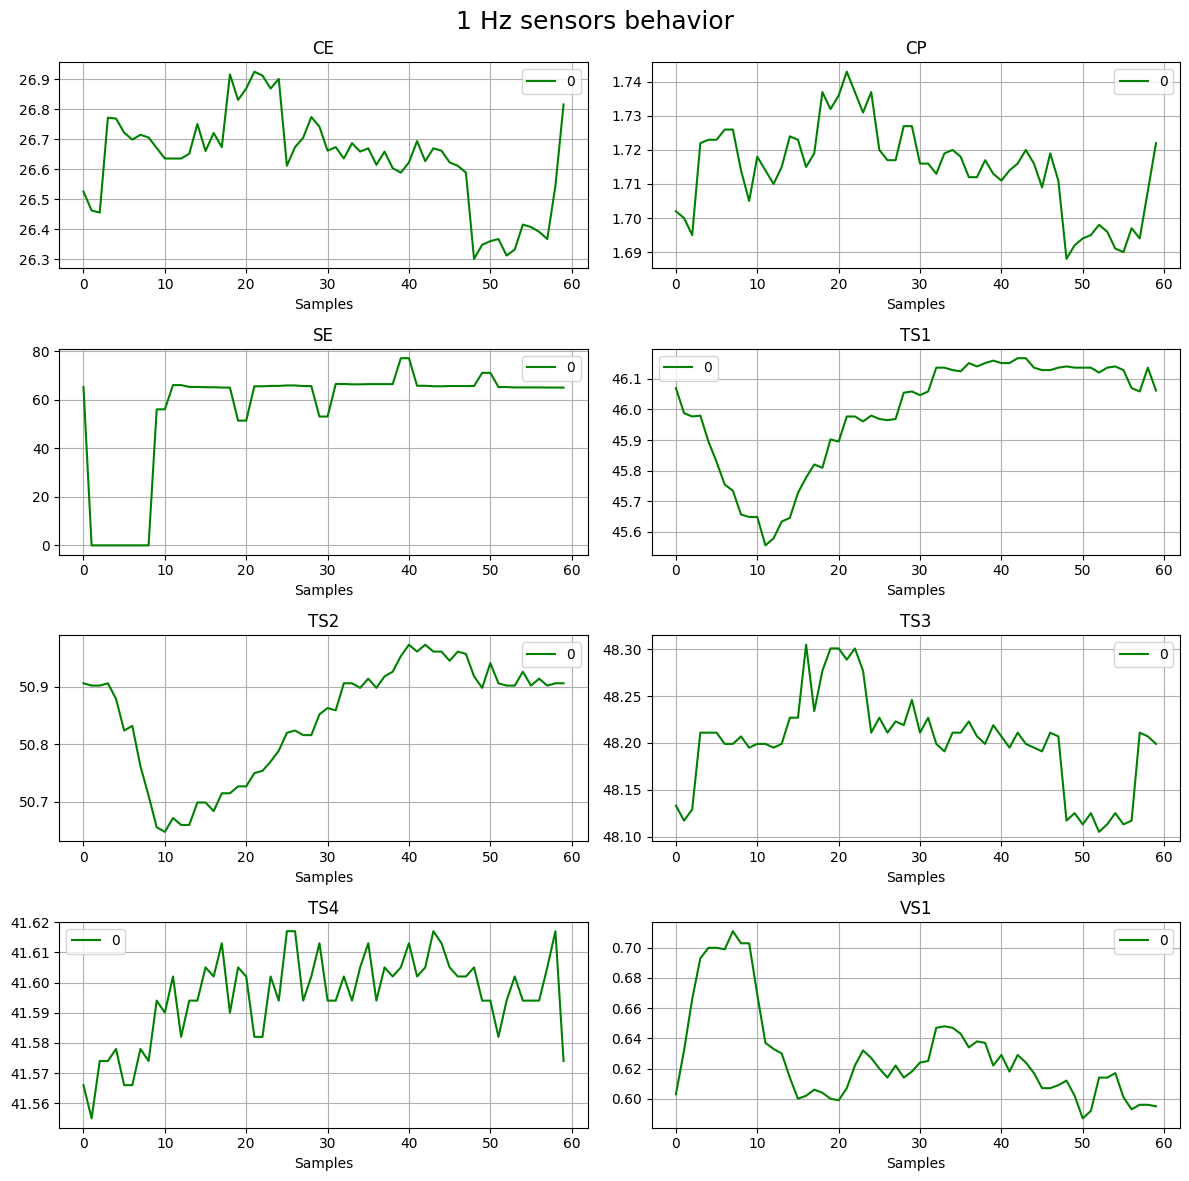

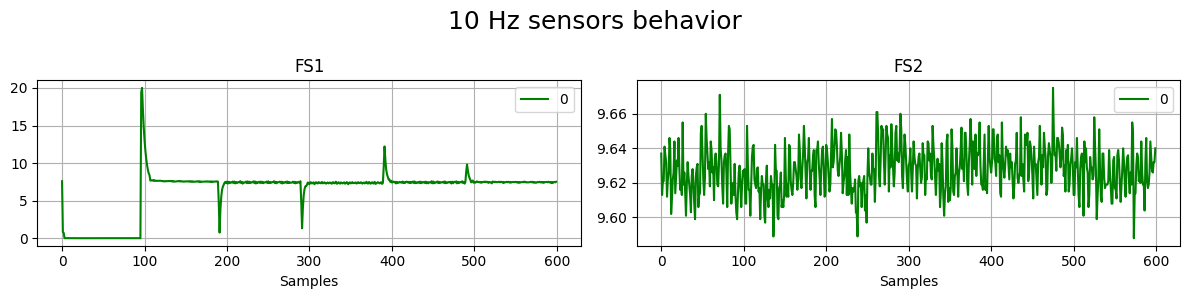

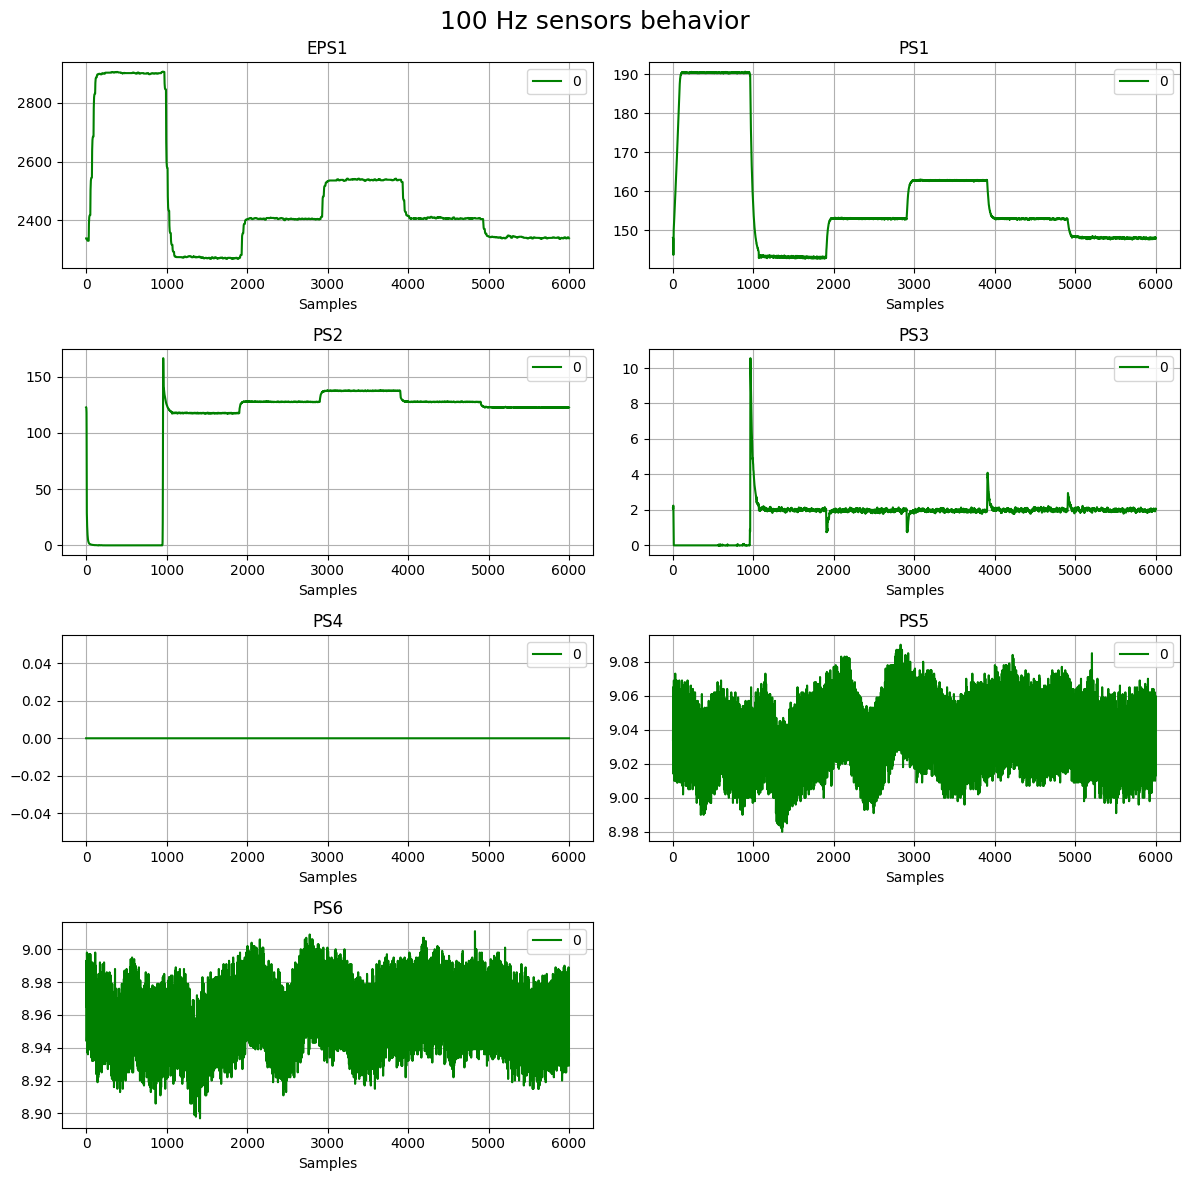

In [20]:
random_experiment_idx = np.random.choice(target.index)
plot_experiment_behavior(one_hz_data, one_hz_names, random_experiment_idx)
plot_experiment_behavior(ten_hz_data, ten_hz_names, random_experiment_idx)
plot_experiment_behavior(hund_hz_data, hund_hz_names, random_experiment_idx)

Check if any sensor has constant value for many experiments.

In [21]:
def calculate_percentage_constant_values(data, names, std_multiplier=1):
    idx_exp_constant_values_sensors = []
    for sensor_idx in range(data.shape[2]):
        n_experiments = data.shape[0]
        samples = data.shape[1]
        sensor_data = data[:,:,sensor_idx]
        # Calculate mean and standard deviation for each experiment
        mean_values = np.mean(sensor_data, axis=1)
        std_values = np.std(sensor_data, axis=1)

        count = 0
        idx_exp_constant_values=[]
        for exp in range(n_experiments):
            
            # Define upper and lower limits for constant values
            upper_limit = mean_values[exp] + std_multiplier * std_values[exp]
            lower_limit = mean_values[exp] - std_multiplier * std_values[exp]
            # Calculate percentage of constant values for the current experiment
            perc_constant_values = 100 * np.sum((sensor_data[exp] >= lower_limit) & (sensor_data[exp] <= upper_limit)) / samples
            # Check if all values in the current experiment are constant
            if perc_constant_values == 100:
                count += 1
                idx_exp_constant_values.append(exp)
        idx_exp_constant_values_sensors.append(idx_exp_constant_values)
                
        # Calculate the percentage of experiments without oscillation for the current sensor
        percentage = round(100*count / n_experiments, 2)
        print(f'The sensor {names[sensor_idx]} has {percentage} % of experiments without oscillation')
    
    return idx_exp_constant_values_sensors

In [22]:
_ = calculate_percentage_constant_values(one_hz_data, one_hz_names)
_ = calculate_percentage_constant_values(ten_hz_data, ten_hz_names)
_ = calculate_percentage_constant_values(hund_hz_data, hund_hz_names)

The sensor CE has 0.0 % of experiments without oscillation
The sensor CP has 0.0 % of experiments without oscillation
The sensor SE has 0.0 % of experiments without oscillation
The sensor TS1 has 0.0 % of experiments without oscillation
The sensor TS2 has 0.0 % of experiments without oscillation
The sensor TS3 has 0.0 % of experiments without oscillation
The sensor TS4 has 0.0 % of experiments without oscillation
The sensor VS1 has 0.0 % of experiments without oscillation
The sensor FS1 has 0.0 % of experiments without oscillation
The sensor FS2 has 0.0 % of experiments without oscillation
The sensor EPS1 has 0.0 % of experiments without oscillation
The sensor PS1 has 0.0 % of experiments without oscillation
The sensor PS2 has 0.0 % of experiments without oscillation
The sensor PS3 has 0.0 % of experiments without oscillation
The sensor PS4 has 56.15 % of experiments without oscillation
The sensor PS5 has 0.0 % of experiments without oscillation
The sensor PS6 has 0.0 % of experiments 

As we can see, the sensor PS4 has no oscilation in most of the experiments. Lets se if we can remove this sensor from the analysis.

In [23]:
def plot_random_experiments_all_conditions(data, names, target):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    conditions = target.unique()
    
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        for condition in conditions:
            experiment_idx = np.random.choice(target[target==condition].index)
            ax.plot(data[experiment_idx,:,sensor_idx], label=condition, color=target_color_dict[condition])
        
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz sensors behavior', fontsize=18)
    plt.tight_layout()
    plt.show()

In [27]:
# plot_random_experiments_all_conditions(one_hz_data, one_hz_names, target)
# plot_random_experiments_all_conditions(ten_hz_data, ten_hz_names, target)
# plot_random_experiments_all_conditions(hund_hz_data, hund_hz_names, target)

In [25]:
def plot_mean_behavior_all_conditions(data, names, target):
    n_cols = 2
    n_sensors = data.shape[2]
    n_rows = ceil(n_sensors/n_cols)
    conditions = target.unique()
    
    freq = int(data.shape[1]/60)
    fig = plt.figure(figsize=(12, 3*n_rows))
    for sensor_idx in range(n_sensors):
        ax = plt.subplot(n_rows,n_cols,sensor_idx+1)
        for condition in conditions:
            idxs_condition = target[target==condition].index
            mean = np.mean(data[idxs_condition,:,sensor_idx],axis=0)
            ax.plot(mean, label=condition, color=target_color_dict[condition])
        
        ax.set_title(names[sensor_idx])
        ax.grid()
        ax.legend()
        ax.set_xlabel('Samples')
    fig.suptitle(f'{freq} Hz mean behavior sensors', fontsize=18)
    plt.tight_layout()
    plt.show()

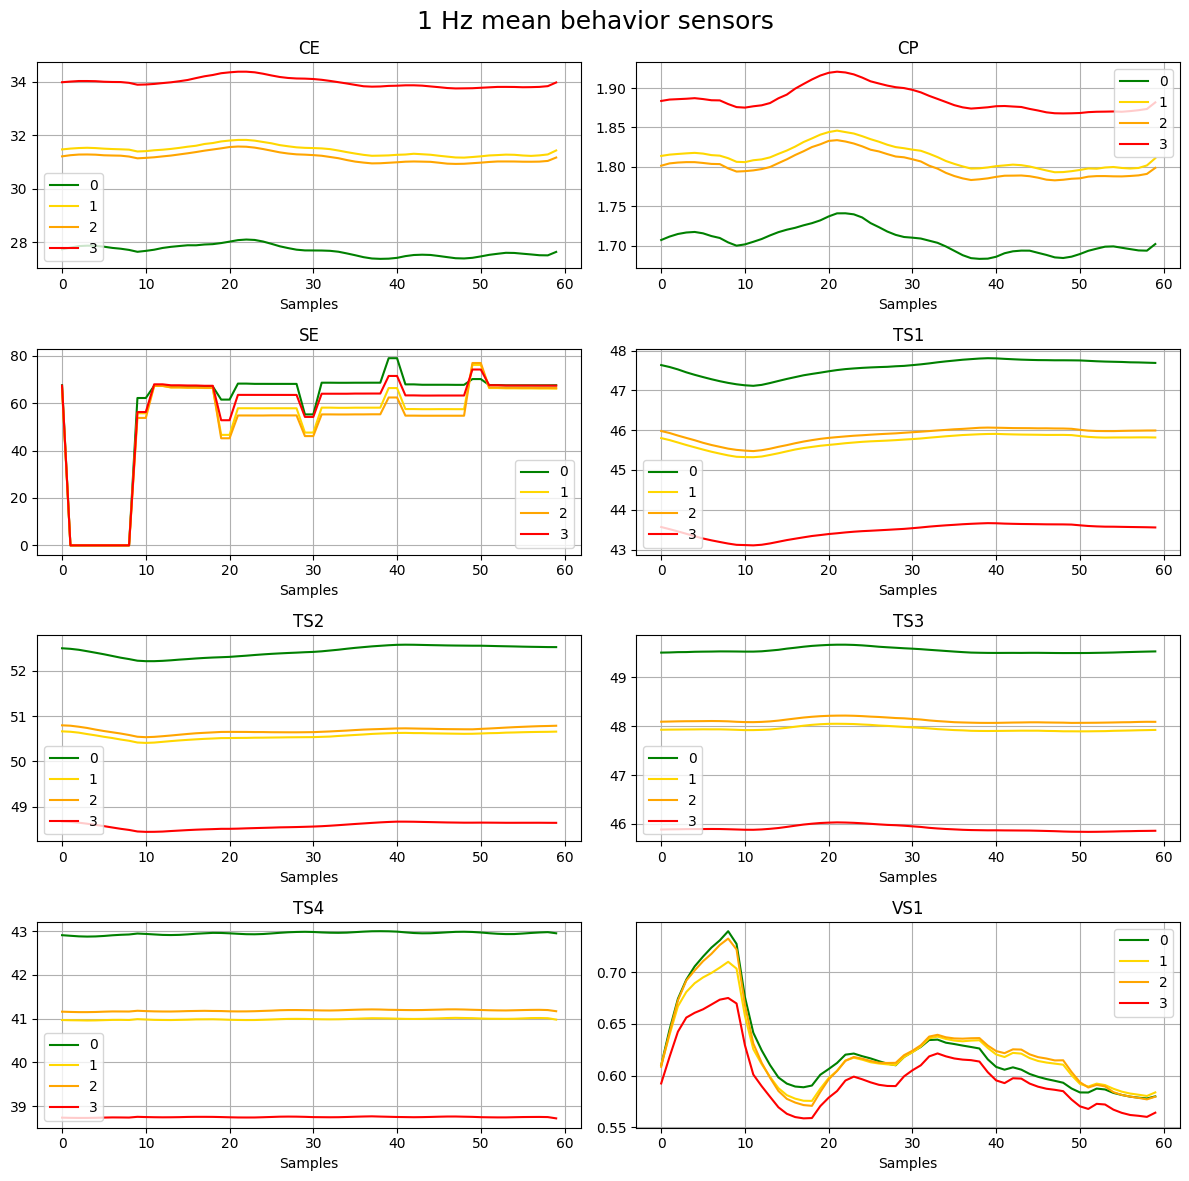

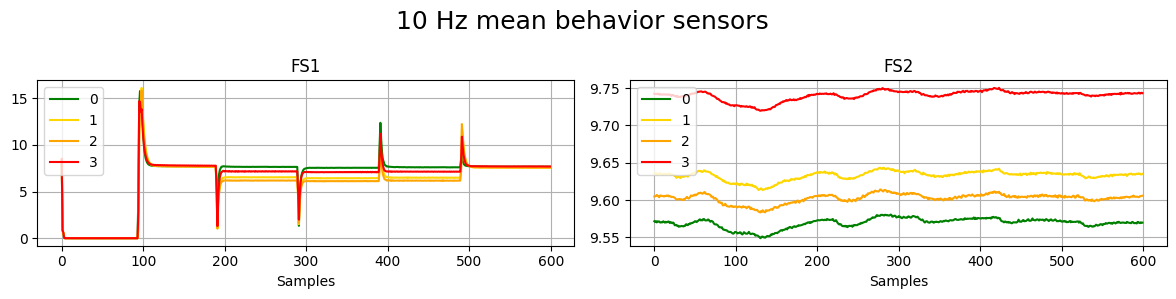

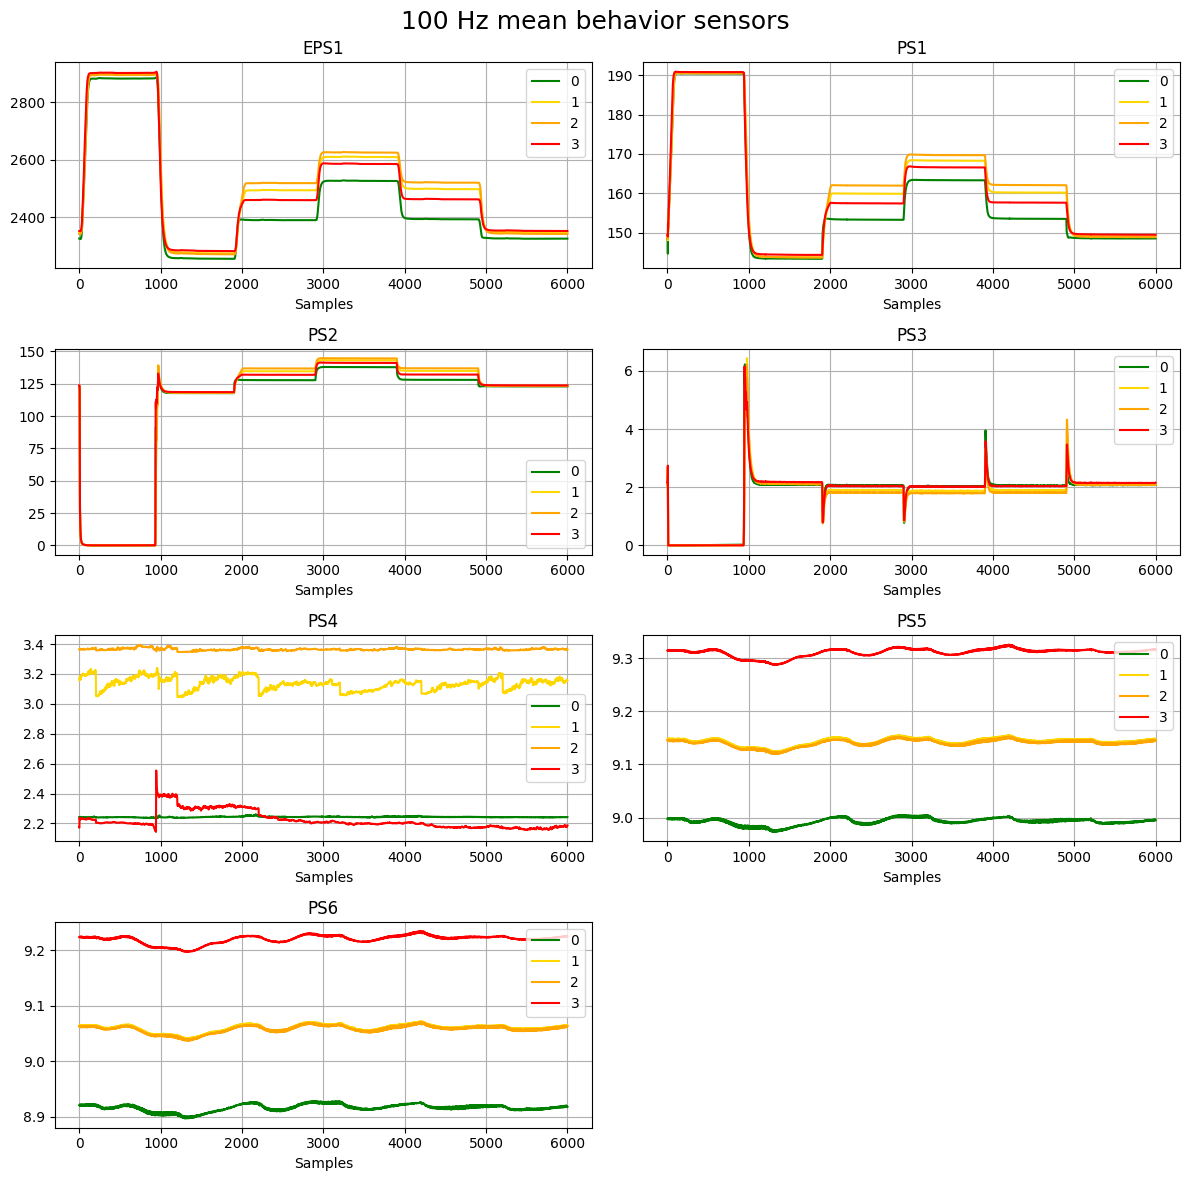

In [26]:
plot_mean_behavior_all_conditions(one_hz_data, one_hz_names, target)
plot_mean_behavior_all_conditions(ten_hz_data, ten_hz_names, target)
plot_mean_behavior_all_conditions(hund_hz_data, hund_hz_names, target)

The plots clearly show that the sensors behave differently depending on the experiment's conditions. Interestingly, conditions 1 and 2 seem to have similar effects on most sensors. So, it might be a good idea to dig deeper and explore other metrics instead of just looking at the average.

Althought the sensor PS4 has most experiments with no oscilation, the avarage behavior has a significant difference beetween the conditions of the experiments, so we CAN'T remove it from the analysis.

## Feature engineering

In [32]:
features_dict = {
    'mean': lambda x:np.mean(x, axis=1),
    'median': lambda x:np.median(x, axis=1),
    'std': lambda x:np.std(x, axis=1),
    'max': lambda x:np.max(x, axis=1),
    'min': lambda x:np.min(x, axis=1),
}

In [38]:
def create_features_df(data, names, features_dict):
    n_sensors = data.shape[2]
    df = pd.DataFrame()
    for sensor_idx in range(n_sensors):
        sensor_name = names[sensor_idx]
        sensor_data = data[:,:,sensor_idx]
        for feat_name, feat in features_dict.items():
            column_name = sensor_name + '_' + feat_name
            column_values = feat(sensor_data)
            df[column_name] = column_values

    return df

In [39]:
one_hz_df = create_features_df(
    one_hz_data,
    one_hz_names,
    features_dict
)

ten_hz_df = create_features_df(
    ten_hz_data,
    ten_hz_names,
    features_dict
)

hund_hz_df = create_features_df(
    hund_hz_data,
    hund_hz_names,
    features_dict
)

In [40]:
df = pd.concat([one_hz_df, ten_hz_df, hund_hz_df], axis=1)

In [43]:
df['target'] = target

In [45]:
df

,CE_mean,CE_median,CE_std,CE_max,CE_min,CP_mean,CP_median,CP_std,CP_max,CP_min,...,PS5_median,PS5_std,PS5_max,PS5_min,PS6_mean,PS6_median,PS6_std,PS6_max,PS6_min,target
0,39.601350,40.6755,6.317224,47.438,28.866,1.862750,1.9240,0.277047,2.188,1.383,...,9.844,0.088147,10.016,9.681,9.728097,9.733,0.085359,9.887,9.568,0
1,25.786433,25.3855,1.672019,29.208,23.320,1.255550,1.2340,0.073981,1.414,1.147,...,9.632,0.038389,9.745,9.557,9.529488,9.526,0.036313,9.637,9.454,0
2,22.218233,22.1040,0.633003,23.554,21.220,1.113217,1.1095,0.023069,1.159,1.076,...,9.528,0.035814,9.640,9.455,9.427949,9.425,0.036028,9.536,9.348,0
3,20.459817,20.4805,0.451941,21.565,19.673,1.062150,1.0660,0.024415,1.107,1.022,...,9.436,0.037065,9.535,9.363,9.337430,9.335,0.037372,9.431,9.257,0
4,19.787017,19.7985,0.287728,20.460,19.133,1.070467,1.0725,0.021297,1.106,1.016,...,9.358,0.029777,9.443,9.290,9.260636,9.260,0.028590,9.342,9.195,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.628517,46.6335,0.235783,47.092,46.242,2.160600,2.1615,0.018019,2.196,2.127,...,9.970,0.022275,10.028,9.910,9.850361,9.849,0.021800,9.905,9.790,3
2201,46.689817,46.6510,0.389641,47.486,45.762,2.151450,2.1485,0.023176,2.200,2.094,...,9.965,0.022021,10.014,9.901,9.844854,9.844,0.021930,9.894,9.777,3
2202,46.472300,46.7005,0.458639,47.206,45.683,2.143300,2.1425,0.026955,2.188,2.099,...,9.964,0.022525,10.019,9.898,9.842628,9.842,0.022092,9.896,9.777,3
2203,46.544967,46.5490,0.240175,47.001,45.846,2.148483,2.1480,0.017628,2.188,2.107,...,9.967,0.023515,10.022,9.898,9.846690,9.846,0.023183,9.900,9.767,3


Fazer um distplot e um scatter plot para trazer mais insights